# Introduction and TCGA background

Liver cancer has the second highest worldwide cancer mortality rate and has limited therapeutic options.

The most common form of liver cancer is hepatocellular carcinoma (HCC), making up 80% of liver cancer cases in the US. HCC is the 9th leading cause of cancer-related deaths in the US, and third worldwide.[1](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga/studied-cancers/liver)


A consortium known as The Cancer Genome Atlas (TCGA) network has made a plethora of molecular information on various cancers, including HCC publicly available. This data include genetic, molecular, diagnostic, demographic, and clinical information from over 350 patients with HCC. 

While surgery can be an effective method for treating early-stage liver cancer, there are few options for more advanced and metastatic tumors. Sorafenib and regorafinib are the only approved treatments for managing advanced HCC, and many others potential therapeutics have failed in Phase III clinical trials. [Previous studies](https://www.cell.com/cell/fulltext/S0092-8674(17)30639-6) studying genomic alterations in samples have found frequently-mutated genes LZTR1, EEF1A1, SF3B1, and SMARCA4.

In addition to DNA alterations however, different biological and tumor microenvrionment factors can influence disease progression. A transcriptomic survey of tissues at various stages of disease progression could help elucidate some of the underlying pathways contributing to tumorigenesis.

## RNA Seq

In this post, we'll be exploring a liver cancer RNA-seq dataset from TCGA. TCGA represents one of the most comprehensive publically-available datasets for cancer research. This tutorial will walk through several steps in how to obtain, process, explore and model gene expression data as it relates to cancer genomics.

In biology, copies of our DNA are used as a template for creating different biological products and proterins. This intermediate copy is known as RNA. Unlike DNA, which is relatively static, RNA can change dynamically depending on environmental factors and stimuli. Technological and commercial advances in next-generation sequencing provided cost-effective methods for conducting RNA-sequencing (RNA-seq) in experiments and a plethora of data. 

Traditionally, RNA is extracted from a sample, and transcribed to a more stable DNA copy(known as complementary DNA because it's the complement to the RNA sample). Sequencing works by attaching one side of each RNA molecule to a surface and repeatedly cycling through a process of attaching colored probes that bind to the RNA, imaging the probe, and washing off the probe. Rinse and repeat.

Following this process we now have tons of strings of T's,C's,G's, and A's that has been barcoded on either side of the sequence. Since each barcode attaches to a known and unique sequence of a gene, we can match these sequences to a reference genome.

Once the sequences have been mapped to their corresponding genes, we now have a quantification of gene expression for our samples. Depending on the question we are looking to answer, comparisons of gene expression between experimental conditions can be used to understand whether particular genetic components and molecular pathways influence that treatment. For instance by performing RNA-seq on normal and tumor liver tissue can show granular differences in actively expressed (or suppressed) genes and provide insight into the role of certain gentic components in influencing tumor progression.

## TODO

Intro to the data


Preparing our data


## Accessing the data

**We'll be focusing on using RNA-seq data from LIHC combined with clinical attributes to identify biomarkers for disease progression.**

TCGA provides raw RNA-seq reads and other clinical data [here](https://portal.gdc.cancer.gov/projects/TCGA-LIHC) and in the R package _[RTCGA](http://rtcga.github.io/RTCGA/)_. This data is already outputted in the accompanying [GitHub](https://github.com/nyhais/hacknights/tree/master/tcga-series/post) as well.

We will be investigating the [Hepatocellular carcinoma dataset(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5680778/). The TCGA RNASeq data is illumina hiseq Level 3 RSEM normalized expression data. You can read about thec RSEM method [here](https://academic.oup.com/bioinformatics/article/26/4/493/243395).

Essentially this is the raw counts of reads that aligned to the gene transcript, though it's only a guess by the program. Since it's a guess, the values are rational numbers. To simplify things, we'll round the values to the next whole integer. 

Before we start any kind of modeling, it's a good idea to observe some high levels patterns within our data to make sure that with all the steps in our process, our data looks accurate.

RNA-seq datasets provide a unique challenge in that they tend to be very wide (~20k genes for a human genome) and short (sequencing information on clinical samples can be expensive or unavailable and certain conditions may be very rare).

In [6]:
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
data_dir=""
response_name="patient.race"
rnaseq_file=data_dir+"../workshop3/lihc_rnaseq.csv.gz"
clinical_file=data_dir+"../workshop1/lihc_clinical.csv.gz"

First let's load the data:

In [8]:
rnaseq = (pd.
          read_csv(rnaseq_file,compression="gzip").
          set_index('bcr_patient_barcode').
          applymap(lambda x : int(np.ceil(x)))
         )
display(rnaseq.shape)
display(rnaseq.head())

(423, 20531)

,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01A-11R-A37K-07,0,2,4,91,1018,0,142,1,0,0,...,25,274,795,19,500,3173,891,511,4,7
TCGA-2Y-A9GS-01A-12R-A38B-07,0,27,3,72,640,0,123,2,0,0,...,69,633,1154,72,1001,5302,756,861,7,483
TCGA-2Y-A9GT-01A-11R-A38B-07,0,0,5,96,743,0,96,2,1,0,...,47,1220,1134,13,1290,3220,861,524,15,84
TCGA-2Y-A9GU-01A-11R-A38B-07,0,6,6,62,1187,0,281,1,0,0,...,19,286,1151,10,942,3093,1340,344,3,3
TCGA-2Y-A9GV-01A-11R-A38B-07,0,12,6,105,879,0,283,0,0,0,...,42,1000,1632,5,1381,2903,576,666,3,120


We can clean up the column titles by extracting the common gene symbols from each.

In [9]:
gene_name_logical = [len(x[0])>1 for x in rnaseq.columns.str.split('|')]
sub = rnaseq.loc[:,gene_name_logical]
sub.columns = [x[0] for x in sub.columns.str.split('|')]
rnaseq_sub = sub.copy()
rnaseq_sub.head()

,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01A-11R-A37K-07,22283,584,0,375,0,286320,81,543,1,1032,...,25,274,795,19,500,3173,891,511,4,7
TCGA-2Y-A9GS-01A-12R-A38B-07,22642,1573,3,99,0,31169,163,2,1,903,...,69,633,1154,72,1001,5302,756,861,7,483
TCGA-2Y-A9GT-01A-11R-A38B-07,77670,1281,0,215,1,19515,119,1,3,773,...,47,1220,1134,13,1290,3220,861,524,15,84
TCGA-2Y-A9GU-01A-11R-A38B-07,9323,1253,0,2914,2,243941,72,0,0,722,...,19,286,1151,10,942,3093,1340,344,3,3
TCGA-2Y-A9GV-01A-11R-A38B-07,84243,1641,0,404,0,8756,83,0,9,828,...,42,1000,1632,5,1381,2903,576,666,3,120


We'll also load the clinical data from TCGA. This contains over a thousand clinical features characterizing the place of care, demographics, and treatment of patients, as well as sample specifications and preparations.

In [10]:
clinical = pd.read_csv(clinical_file,compression="gzip").set_index('patient.bcr_patient_barcode')
display(clinical.shape)
display(clinical.head())

(377, 1586)

,admin.bcr,admin.day_of_dcc_upload,admin.disease_code,admin.file_uuid,admin.month_of_dcc_upload,admin.patient_withdrawal.withdrawn,admin.project_code,admin.year_of_dcc_upload,patient.ablation_embolization_tx_adjuvant,patient.additional_studies,...,patient.samples.sample.preservation_method,patient.samples.sample.sample_type,patient.samples.sample.sample_type_id,patient.samples.sample.shortest_dimension,patient.samples.sample.time_between_clamping_and_freezing,patient.samples.sample.time_between_excision_and_freezing,patient.samples.sample.tissue_type,patient.samples.sample.tumor_descriptor,patient.samples.sample.tumor_pathology,patient.samples.sample.vial_number
patient.bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
tcga-2v-a95s,nationwide children's hospital,1,lihc,47a9da83-f87b-45a0-a501-542c5a9df212,10,False,tcga,2015,no,NaN,...,NaN,primary tumor,1,NaN,NaN,NaN,NaN,NaN,NaN,a
tcga-2y-a9gs,nationwide children's hospital,1,lihc,ada84bc2-9724-428c-9557-7280af5f8297,10,False,tcga,2015,no,NaN,...,NaN,primary tumor,1,NaN,NaN,NaN,NaN,NaN,NaN,a
tcga-2y-a9gt,nationwide children's hospital,1,lihc,b9f63d47-2293-4360-b373-5acdaa2ec7cb,10,False,tcga,2015,NaN,NaN,...,NaN,primary tumor,1,NaN,NaN,NaN,NaN,NaN,NaN,a
tcga-2y-a9gu,nationwide children's hospital,1,lihc,2b488ba2-f46b-4d0b-8c73-d9a761ab61b1,10,False,tcga,2015,no,NaN,...,NaN,primary tumor,1,NaN,NaN,NaN,NaN,NaN,NaN,a
tcga-2y-a9gv,nationwide children's hospital,1,lihc,69fc70f4-fe6a-472a-b354-cf37515c524d,10,False,tcga,2015,no,NaN,...,NaN,primary tumor,1,NaN,NaN,NaN,NaN,NaN,NaN,a


## Exploratory data analysis

We can start by taking a look at the range of expression and distribution of geneset. Since we have 20k of themwhether certain genes are more highhigher or lower than the average level of 


RNA seq typically follows a negative bionomial distribution. If we take a look at the standard deviation of the log mean values vs the log of mean counts for each gene/transcript across patient samples.

Dispersion is a parameter that estimates variability within negative binomial distribution. Analagous for variance for normal distribution. Because never sampling randomly, dispersion does not penalize differences from mean.

In [11]:
exprs_genes = rnaseq_sub[rnaseq_sub>0].dropna(axis=1)
mean_vec = exprs_genes.mean().apply(np.log)
sd_vec = exprs_genes.std().apply(np.log)

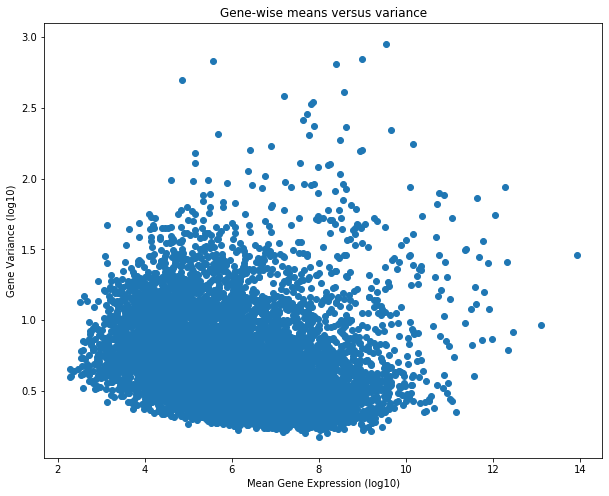

In [51]:
mean_vec = exprs_genes.apply(np.log).mean()
sd_vec = exprs_genes.apply(np.log).std()
fig = plt.figure(figsize=(10,8))
plt.scatter(mean_vec, sd_vec)
plt.title('Gene-wise means versus variance')
plt.xlabel('Mean Gene Expression (log10)')
plt.ylabel('Gene Variance (log10)');

It is obvious that the variance of counts is generally greater than their mean, especially for genes expressed at a higher level. This phenomenon is called “overdispersion“. The NB distribution is similar to a Poisson distribution but has an extra parameter called the “clumping” or “dispersion” parameter. It is like a Poisson distribution with more variance. Note, how the NB estimates of the mean-variance relationship (blue line) fits the observed values quite well. Thus, a reasonable first intuition of why the NB distribution is a proper way of fitting count data is that the dispersion parameter allows the extra wiggle room to model the “extra” variance that we empirically observe in RNA-Seq experiments.

Let's choose a couple genes known to be related to the hallmarks of cancer. In the Github repo, you'll find a list of genes associated with the major hallmarks of cancer.

In [1]:
import pickle

In [3]:
gene_dict = pickle.load(open('hallmarks_of_cancer_geneset_dictionary.pkl', 'rb'))

In [4]:
gene_dict

{'HALLMARK_ADIPOGENESIS': array(['ABCA1', 'ABCB8', 'ACAA2', 'ACADL', 'ACADM', 'ACADS', 'ACLY',
        'ACO2', 'ACOX1', 'ADCY6', 'ADIG', 'ADIPOQ', 'ADIPOR2', 'AGPAT3',
        'AIFM1', 'AK2', 'ALDH2', 'ALDOA', 'ANGPT1', 'ANGPTL4', 'APLP2',
        'APOE', 'ARAF', 'ARL4A', 'ATL2', 'ATP1B3', 'ATP5PO', 'BAZ2A',
        'BCKDHA', 'BCL2L13', 'BCL6', 'C3', 'CAT', 'CAVIN1', 'CAVIN2',
        'CCNG2', 'CD151', 'CD302', 'CD36', 'CDKN2C', 'CHCHD10', 'CHUK',
        'CIDEA', 'CMBL', 'CMPK1', 'COL15A1', 'COL4A1', 'COQ3', 'COQ5',
        'COQ9', 'COX6A1', 'COX7B', 'COX8A', 'CPT2', 'CRAT', 'CS', 'CYC1',
        'CYP4B1', 'DBT', 'DDT', 'DECR1', 'DGAT1', 'DHCR7', 'DHRS7',
        'DHRS7B', 'DLAT', 'DLD', 'DNAJB9', 'DNAJC15', 'DRAM2', 'ECH1',
        'ECHS1', 'ELMOD3', 'ELOVL6', 'ENPP2', 'EPHX2', 'ESRRA', 'ESYT1',
        'ETFB', 'FABP4', 'FAH', 'FZD4', 'G3BP2', 'GADD45A', 'GBE1',
        'GHITM', 'GPAM', 'GPAT4', 'GPD2', 'GPHN', 'GPX3', 'GPX4', 'GRPEL1',
        'HADH', 'HIBCH', 'HSPB8', 'IDH1', 'IDH3

Loading the dictionary, we see that apoptosis, or programmed cell death, is one of the Hallmarks of Cancer. Let's look at the range of expression for a subset of genes across patient samples related to apoptosis.

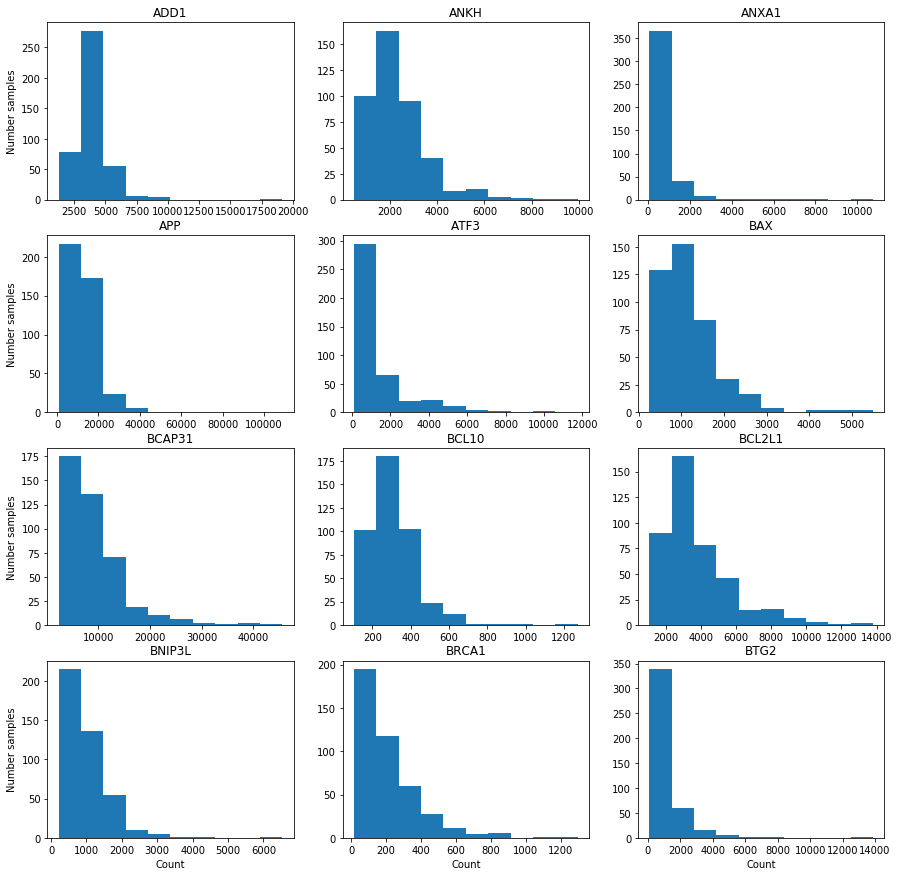

In [35]:
# Plot range of gene expression values
rows, cols = 4, 3
fig, axs = plt.subplots(rows, cols, figsize=(15,15))
genes = ['ADD1', 'ANKH', 'ANXA1', 'APP', 'ATF3', 'BAX', 'BCAP31', 'BCL10', 'BCL2L1', 'BNIP3L', 'BRCA1', 'BTG2']
i = 0
for row in range(rows):
    for col in range(cols):
        axs[row, col].hist(exprs_genes[genes[i]].values)
        axs[row, col].title.set_text(genes[i])
        if col%3 == 0:
            axs[row, col].set_ylabel('Number samples')
        if row >= 3:
            axs[row, col].set_xlabel('Count')
        i += 1



Just by looking at a few of these genes, we can see that expression varies differently between tumor samples. Some genes tend to have a heavy left skew, while others tend to cluster above low expression. We can also see that the range of values varies greatly both within and between genes.

In [ ]:
Questions:
What is the range of values for a given gene?
What is the distribution of values for a given gene?
Are there higher than average or lower than average expression of genes?
Which genes are differentially expressed? Are they positively or negatively expressed compared to your control?
What do these genes do? Which pathways are they involved in?
Are there related clinical phenotypes which might show similar differences in expression?
How many unique values are there for a given clinical attribute?
How can we define an appropriate response variable for supervised learning?
What clinical attributes can be used to identify biomarkers for disease progression?
Background and problem setting - Matt
Liver Cancer
TCGA
RNA-seq and data introduction
Setting up Spell AI platform - Nick
EDA - Matt/Nick
